In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ast import literal_eval
from typing import List, Tuple
import os
import string
import sys
import torch
import torch.nn as nn
from scipy.spatial.distance import squareform, pdist, cdist
from Bio import SeqIO
import esm
torch.set_grad_enabled(False)
from einops import rearrange
import gc
import matplotlib.patches as mpatches
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Select the GPU to run on
cuda = torch.device('cuda:1')
torch.cuda.set_device(1)

In [4]:
df_rmsds = pd.read_csv('../data/rmsd_dataset.csv')

In [5]:
def get_query_tensor(query_path):
    query = torch.load(query_path)
    return query


def get_rmsd_label(df_rmsds, pdb_id):
    labels = literal_eval(df_rmsds[df_rmsds['Unnamed: 0'].str.contains(pdb_id[:4].lower())].iloc[0, 1])
    return labels


def normalize(data):
    #data = np.reshape(data, (1, len(data)))
    data = data - np.mean(data)
    data = data / np.std(data)
    return data


def display_heatmap(data, title):
    # Change the data to a numpy array
    data = np.array(data)

    # If the data is a 1D array, reshape it to 2D
    if len(data.shape) == 1:
        data = np.reshape(data, (1, len(data)))

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(data, cmap='viridis', square=True, cbar=False, xticklabels=10, yticklabels=10)
    plt.title(title)
    plt.show()


def display_lineplot(data_1, data_2, title):
    # Plot the lineplot
    fig, ax = plt.subplots(figsize=(8, 2))
    sns.lineplot(data=data_1)
    sns.lineplot(data=data_2)
    plt.title(title)
    plt.show()

In [6]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)


def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA.
    Source: The ESM-2 notebook 'contact_prediction.ipynb'.
    """
    return sequence.translate(translation)


def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions.
    Source: The ESM-2 notebook 'contact_prediction.ipynb'.
    """
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]


def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    """ Select sequences from the MSA to maximize the hamming distance.
    Source: The ESM-2 notebook 'contact_prediction.ipynb'.
    """
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa

    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]


def make_query_matrices(pdb_id, msa_directory='/home/vera/projects/masters_project/data/alignments/', sequence_count=128, start_index=0):

    msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
    msa_transformer = msa_transformer.eval().cuda()
    msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

    # Make sure the PDB ID is in the right format
    if len(pdb_id) == 5:
        pdb_id = pdb_id[:4] + '_' + pdb_id[4]

    msa_path = os.path.join(msa_directory, 'aligned_' + pdb_id + '.a3m')
    
    # Run MSA Transformer if the MSA input file exists and embeddings output file doesn't exist
    if not os.path.isfile(msa_path):
        print('ERROR: The MSA file "' + msa_path + '" does not exist!')
        return None
    
    torch.cuda.empty_cache()
    inputs = read_msa(msa_path)

    inputs = greedy_select(inputs, num_seqs=sequence_count)
    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
    
    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
    
    with torch.no_grad():
        result = msa_transformer(msa_transformer_batch_tokens, repr_layers=[], need_head_weights=True, return_contacts=True)
    
    column_attentions = result['col_attentions'][0].cpu().numpy()
    query_row_heads = column_attentions[:, :, :, :, 0]
    query_col_heads = column_attentions[:, :, :, 0, :]
    # Flatten the first two dimensions into one
    query_row_heads = np.reshape(query_row_heads, (query_row_heads.shape[0] * query_row_heads.shape[1], query_row_heads.shape[2], query_row_heads.shape[3]))
    query_col_heads = np.reshape(query_col_heads, (query_col_heads.shape[0] * query_col_heads.shape[1], query_col_heads.shape[2], query_col_heads.shape[3]))
    query_heads = np.stack((query_row_heads, query_col_heads), axis=0)
    query_heads = np.swapaxes(query_heads, -1, -2)

    gc.collect()
    torch.cuda.empty_cache()
            
    return query_heads


def make_summed_matrix(pdb_id, msa_directory='/home/vera/projects/masters_project/data/alignments/', sequence_count=128, start_index=0):

    msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
    msa_transformer = msa_transformer.eval().cuda()
    msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

    # Make sure the PDB ID is in the right format
    if len(pdb_id) == 5:
        pdb_id = pdb_id[:4] + '_' + pdb_id[4]

    msa_path = os.path.join(msa_directory, 'aligned_' + pdb_id + '.a3m')
    
    # Run MSA Transformer if the MSA input file exists and embeddings output file doesn't exist
    if not os.path.isfile(msa_path):
        print('ERROR: The MSA file "' + msa_path + '" does not exist!')
        return None
    
    torch.cuda.empty_cache()
    inputs = read_msa(msa_path)

    inputs = greedy_select(inputs, num_seqs=sequence_count)
    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
    
    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
    
    with torch.no_grad():
        result = msa_transformer(msa_transformer_batch_tokens, repr_layers=[], need_head_weights=True, return_contacts=True)
    
    column_attentions = result['col_attentions'][0].cpu().numpy()
    print(column_attentions.shape)

    summed_matrix = np.sum(column_attentions, axis=(0,1,3))
    summed_matrix = np.transpose(summed_matrix)

    gc.collect()
    torch.cuda.empty_cache()
            
    return summed_matrix

In [7]:
DATA_PATH = '../data/query_col_attentions/'
query_attention_files = os.listdir(DATA_PATH)

df = pd.read_csv('../backup/data/cluster_ids_out.csv')

# Sort in descending order according to rmsd
df.sort_values(by='rmsd', ascending=False, inplace=True)
#top_names = df['pdb_id'].tolist()

existing_files = {}

# Iterate over every row in the dataframe
for index, row in df.iterrows():
    name = row['pdb_id']
    rmsd = row['rmsd']
    pdb_id = name[:4].lower() + '_' + name[4].lower()
    path = 'query_col_attentions_' + pdb_id + '_128.pt'

    if path in query_attention_files and df_rmsds['Unnamed: 0'].str.contains(pdb_id[:4].lower()).any():
        labels = labels = get_rmsd_label(df_rmsds, pdb_id)
        existing_files[pdb_id] = {
        "path": path,
        "rmsd": rmsd,
        "labels": labels
    }

print(len(df))
print(len(existing_files))

38341
5622


## Figure 18a

(12, 12, 293, 128, 128)


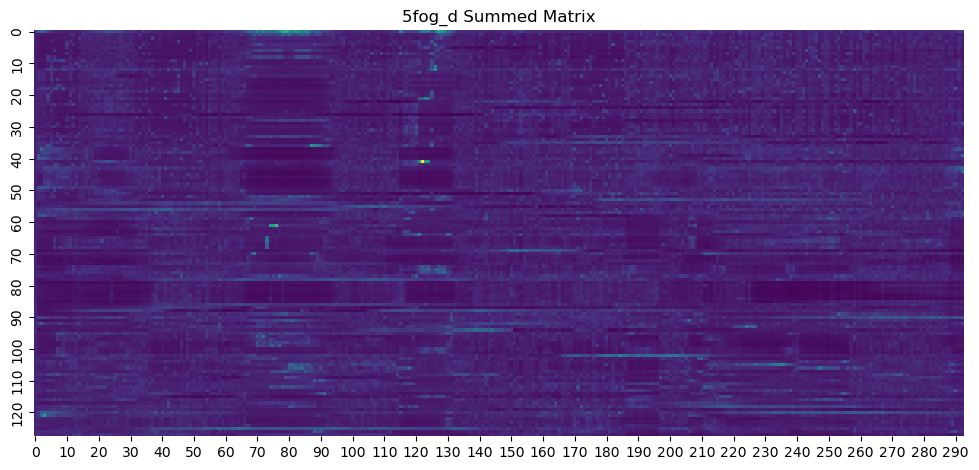

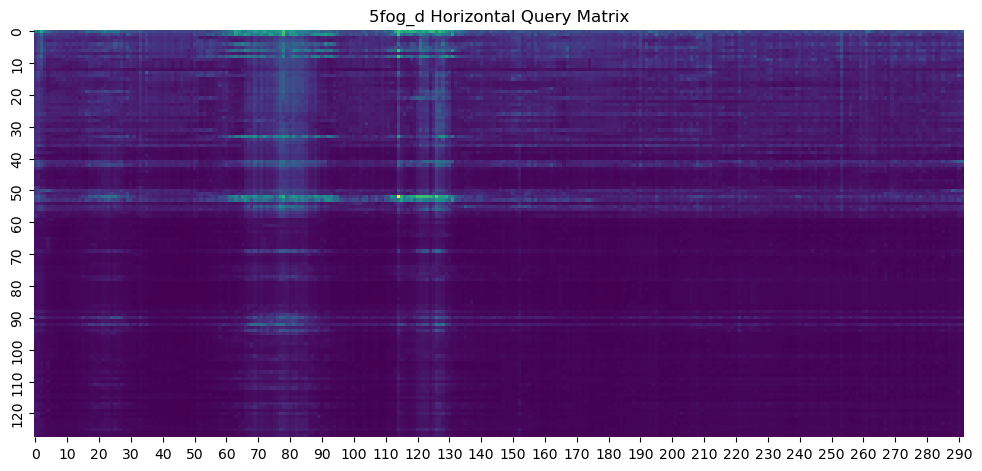

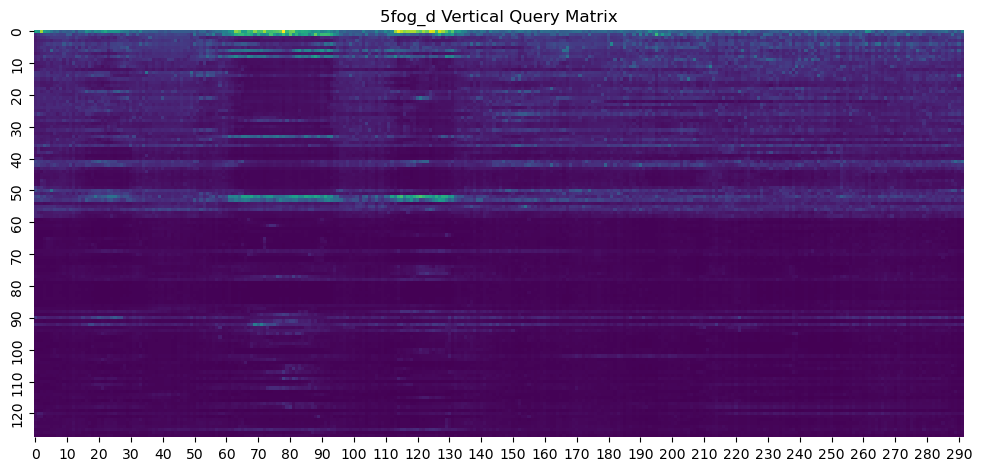

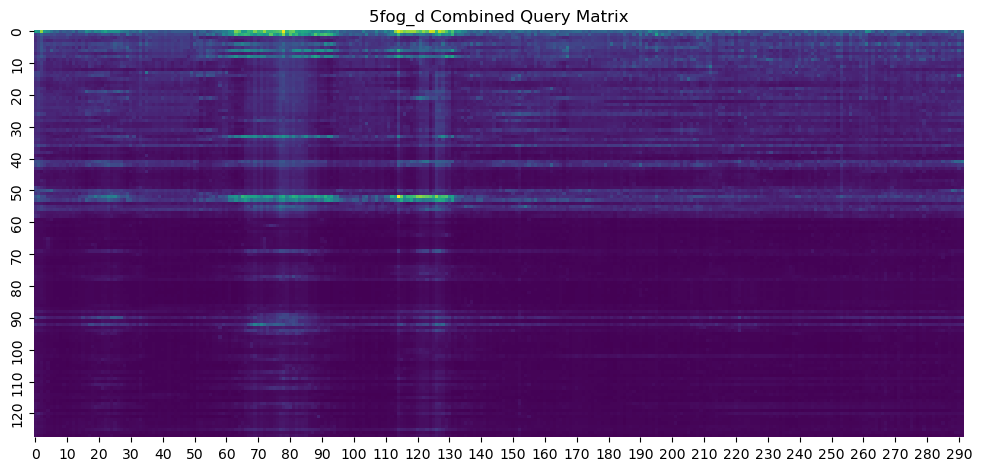

In [14]:
pdb = '5fog_d'

summed_matrix = make_summed_matrix(pdb, sequence_count=128)
display_heatmap(summed_matrix, f'{pdb} Summed Matrix')

query_matrix = make_query_matrices(pdb, sequence_count=128)[:, :, :, 1:]
summed_query = query_matrix.sum(axis=1)

horizontal = summed_query[0, :, :]
vertical = summed_query[1, :, :]
combined = vertical + horizontal

display_heatmap(horizontal, f'{pdb} Horizontal Query Matrix')
display_heatmap(vertical, f'{pdb} Vertical Query Matrix')
display_heatmap(combined, f'{pdb} Combined Query Matrix')

## Figure 18b

(12, 12, 138, 128, 128)


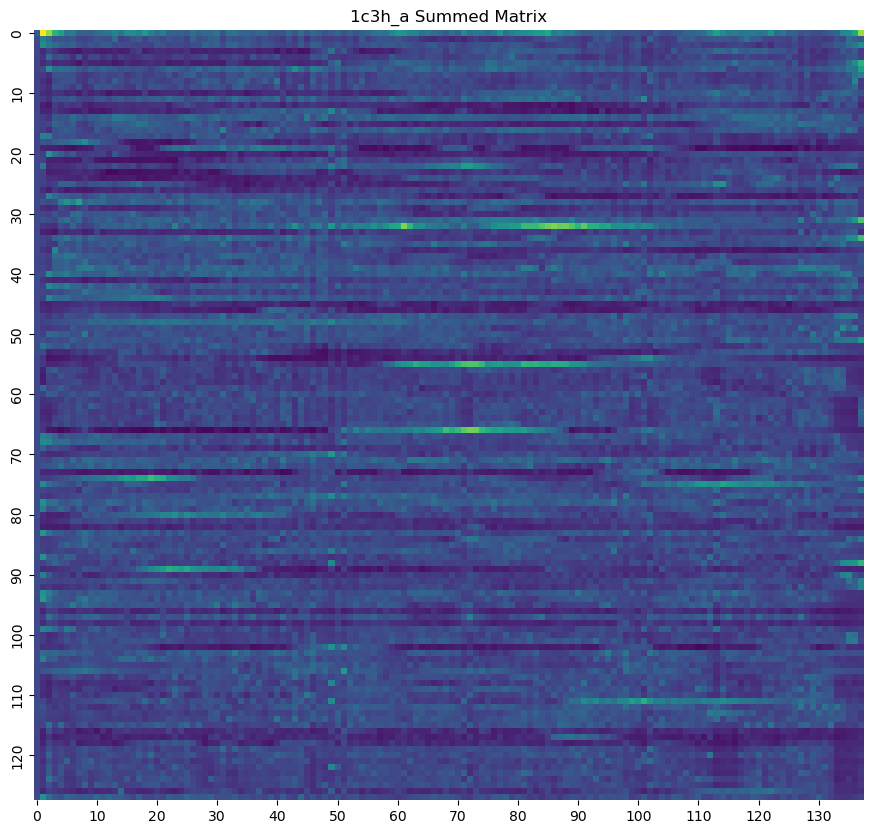

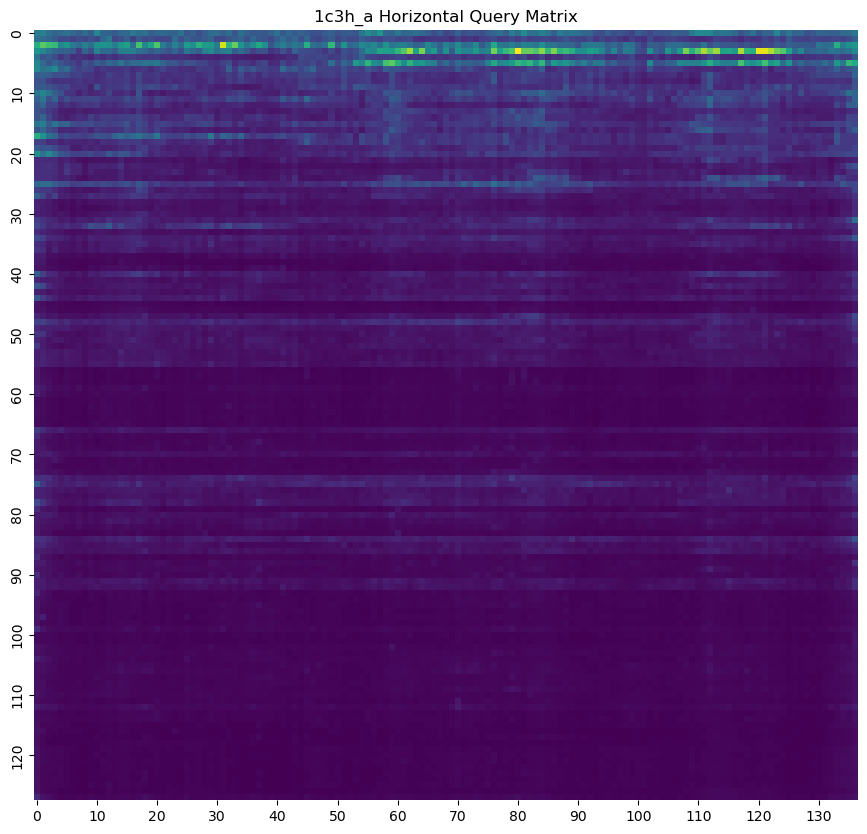

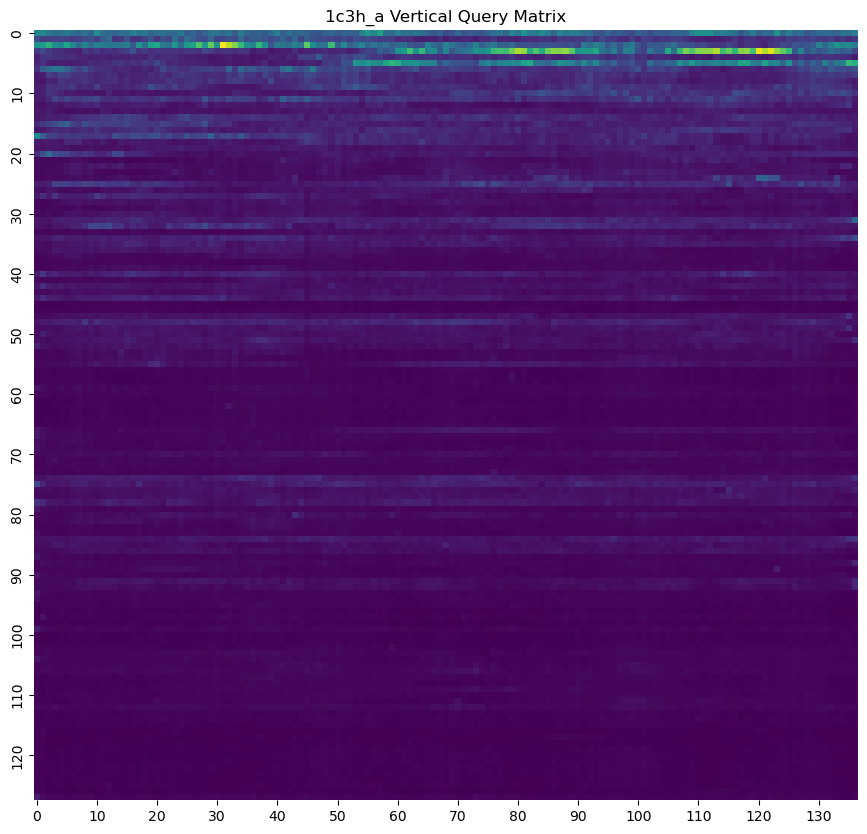

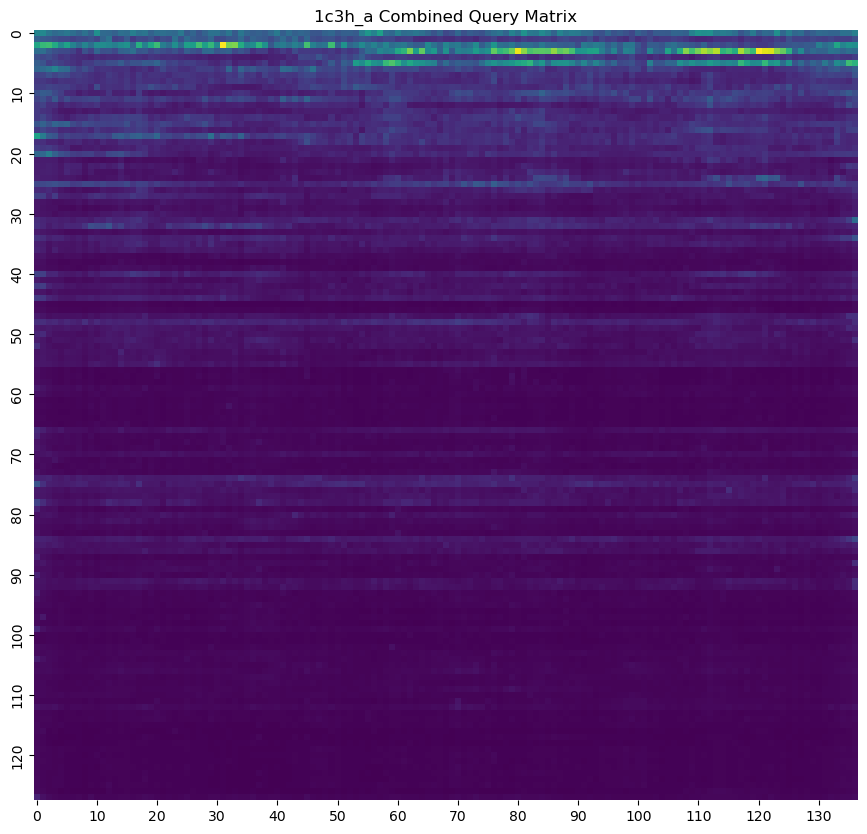

In [15]:
pdb = '1c3h_a'

summed_matrix = make_summed_matrix(pdb, sequence_count=128)
display_heatmap(summed_matrix, f'{pdb} Summed Matrix')

query_matrix = make_query_matrices(pdb, sequence_count=128)[:, :, :, 1:]
summed_query = query_matrix.sum(axis=1)

horizontal = summed_query[0, :, :]
vertical = summed_query[1, :, :]
combined = vertical + horizontal

display_heatmap(horizontal, f'{pdb} Horizontal Query Matrix')
display_heatmap(vertical, f'{pdb} Vertical Query Matrix')
display_heatmap(combined, f'{pdb} Combined Query Matrix')

## Figure 19a

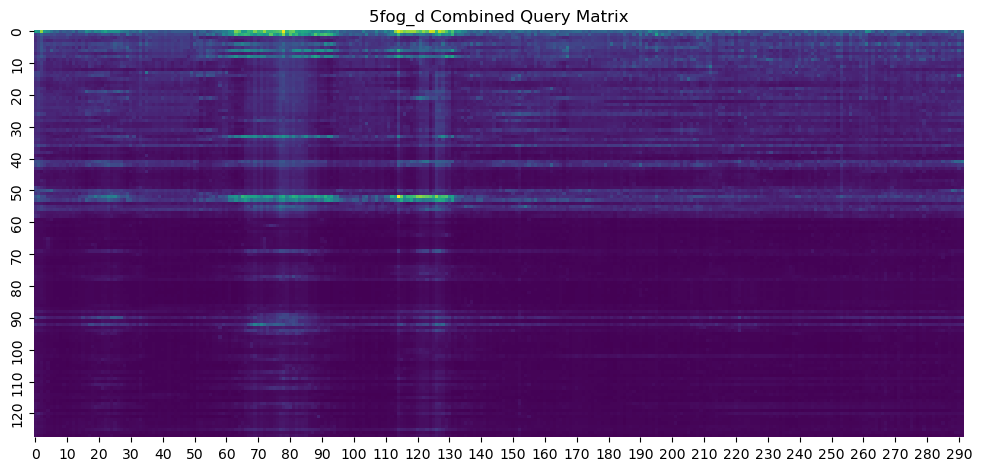

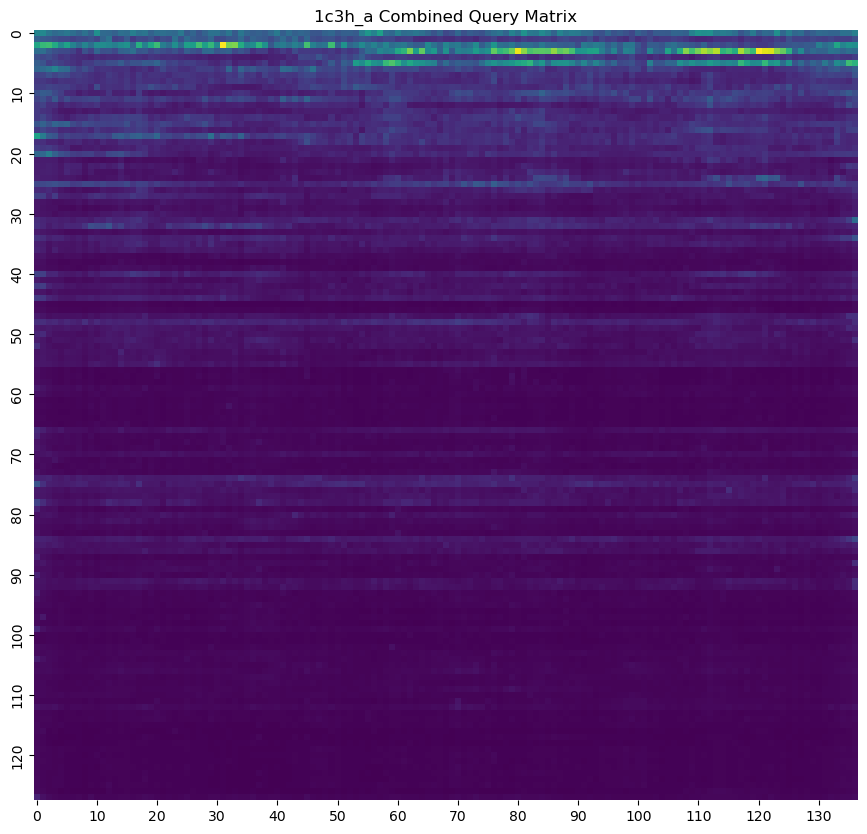

In [16]:
pdb = '5fog_d'

query_matrix = make_query_matrices(pdb, sequence_count=128)[:, :, :, 1:]
summed_query = query_matrix.sum(axis=1)

horizontal = summed_query[0, :, :]
vertical = summed_query[1, :, :]
combined = vertical + horizontal
display_heatmap(combined, f'{pdb} Combined Query Matrix')


pdb = '1c3h_a'

query_matrix = make_query_matrices(pdb, sequence_count=128)[:, :, :, 1:]
summed_query = query_matrix.sum(axis=1)

horizontal = summed_query[0, :, :]
vertical = summed_query[1, :, :]
combined = vertical + horizontal
display_heatmap(combined, f'{pdb} Combined Query Matrix')

## Figure 19b

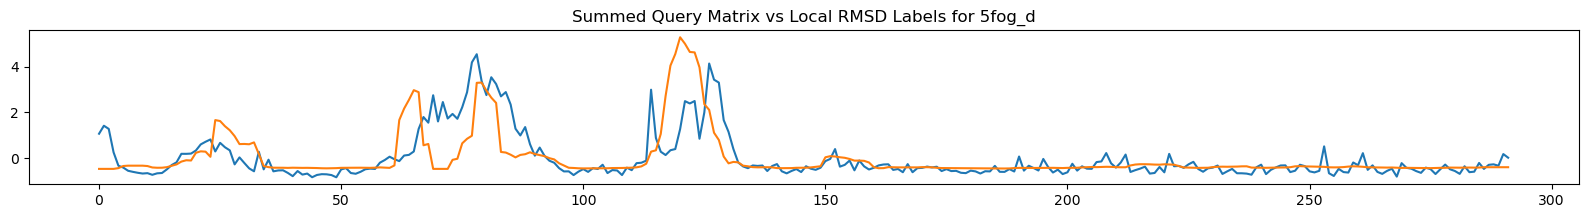

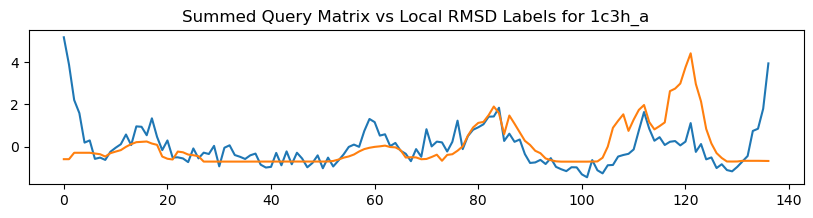

In [23]:
def display_lineplot(data_1, data_2, title):
    # Plot the lineplot
    fig, ax = plt.subplots(figsize=(8, 2))
    sns.lineplot(data=data_1)
    sns.lineplot(data=data_2)
    plt.title(title)
    plt.show()

pdb = '5fog_d'

query_matrix = make_query_matrices(pdb, sequence_count=128)[:, :, :, 1:]
summed_query = query_matrix.sum(axis=1)

horizontal = summed_query[0, :, :]
vertical = summed_query[1, :, :]
combined = vertical + horizontal
combined_sum = combined.sum(axis=0)
activations = normalize(combined_sum)
labels = normalize(existing_files[pdb]['labels'])

fig, ax = plt.subplots(figsize=(20, 2))
sns.lineplot(data=activations)
sns.lineplot(data=labels)
plt.title("Summed Query Matrix vs Local RMSD Labels for " + pdb)
plt.show()


pdb = '1c3h_a'

query_matrix = make_query_matrices(pdb, sequence_count=128)[:, :, :, 1:]
summed_query = query_matrix.sum(axis=1)

horizontal = summed_query[0, :, :]
vertical = summed_query[1, :, :]
combined = vertical + horizontal
combined_sum = combined.sum(axis=0)
activations = normalize(combined_sum)
labels = normalize(existing_files[pdb]['labels'])

fig, ax = plt.subplots(figsize=(10, 2))
sns.lineplot(data=activations)
sns.lineplot(data=labels)
plt.title("Summed Query Matrix vs Local RMSD Labels for " + pdb)
plt.show()

## Figure 20

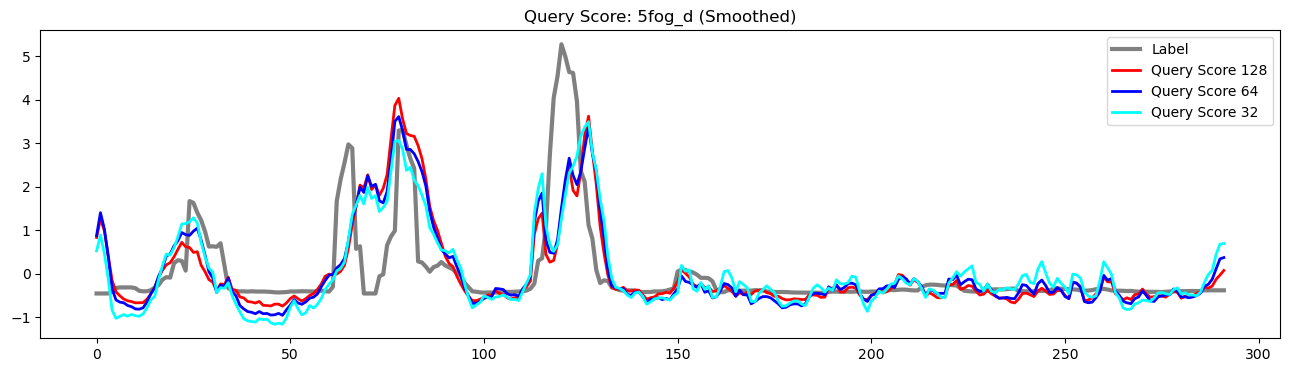

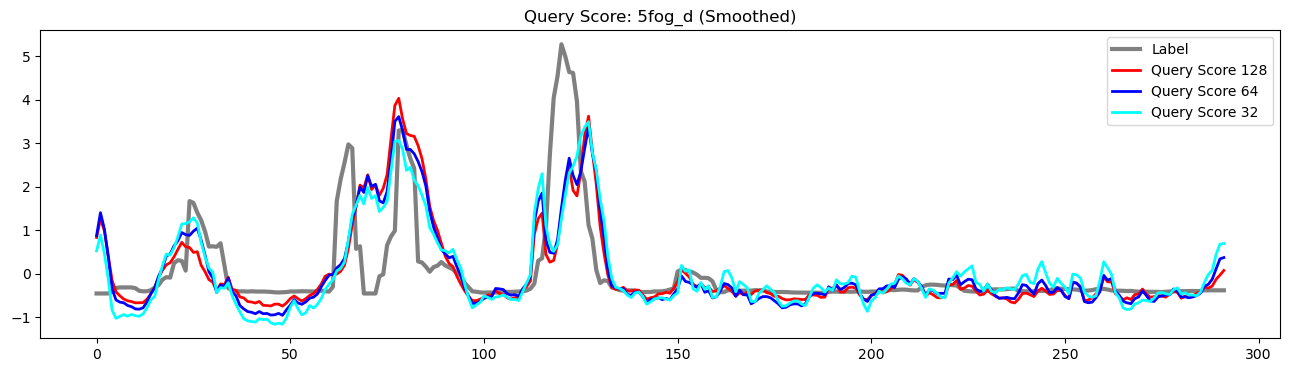

In [9]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def normalise(data):
    data = np.reshape(data, (1, len(data)))
    data = data - np.mean(data)
    data = data / np.std(data)
    return data

def get_activations(pdb, sequence_count):
    query_matrix = make_query_matrices(pdb, sequence_count=sequence_count)[:, :, :, 1:]
    summed_query = query_matrix.sum(axis=1)
    horizontal = summed_query[0, :, :]
    vertical = summed_query[1, :, :]
    combined = vertical + horizontal
    combined_sum = combined.sum(axis=0)
    activations = normalise(combined_sum)
    return activations


pdb = '5fog_d'

activations_128 = get_activations(pdb, 128)
activations_64 = get_activations(pdb, 64)
activations_32 = get_activations(pdb, 32)
labels = existing_files[pdb]['labels']
labels = normalise(labels)

fig = plt.figure(figsize=(16, 4))
plt.plot(labels[0], lw=3, color='grey')
plt.plot(smooth(activations_128[0],3), lw=2, color='red')
plt.plot(smooth(activations_64[0],3), lw=2, color='blue')
plt.plot(smooth(activations_32[0],3), lw=2, color='cyan')
plt.title("Query Score: " + pdb + " (Smoothed)")
plt.legend(['Label', 'Query Score 128', 'Query Score 64', 'Query Score 32'])
plt.show()


pdb = '1c3h_a'

activations_128 = get_activations(pdb, 128)
activations_64 = get_activations(pdb, 64)
activations_32 = get_activations(pdb, 32)
labels = existing_files[pdb]['labels']
labels = normalise(labels)

fig = plt.figure(figsize=(16, 4))
plt.plot(labels[0], lw=3, color='grey')
plt.plot(smooth(activations_128[0],3), lw=2, color='red')
plt.plot(smooth(activations_64[0],3), lw=2, color='blue')
plt.plot(smooth(activations_32[0],3), lw=2, color='cyan')
plt.title("Query Score: " + pdb + " (Smoothed)")
plt.legend(['Label', 'Query Score 128', 'Query Score 64', 'Query Score 32'])
plt.show()